# Approach 0: Naive Stationary Gaussian Process

- **Method**: Use a standard Gaussian Process with a stationary kernel, where the length-scale remains constant across the entire domain.  
- **Implementation**: Select a common kernel (e.g., RBF, Matérn) and train the GP using standard optimization techniques to fit the kernel parameters, including the global length-scale.  
- **Pros**:  
  - Simple to implement and computationally efficient.  
- **Cons**:  
  - Cannot capture varying length-scales in different regions of the data.  
  - May lead to underfitting in regions with high-frequency variations or overfitting in smoother regions.

In [1]:
# Imports

import gpytorch
import numpy as np
import plotly.graph_objects as go
import torch
from IPython.display import Image

import utils

image_type = "static"  # html / static

## Inputs

In [2]:
# Load input data

filename_identifier = "D"

# Target data files
filename_true = f"data/true_data_{filename_identifier}.csv"
filename_obs = f"data/observed_data_{filename_identifier}.csv"

# Load as tensors
true_x, true_y, obs_x, obs_y = utils.load_true_and_obs_tensors(
    filename_true,
    filename_obs,
)

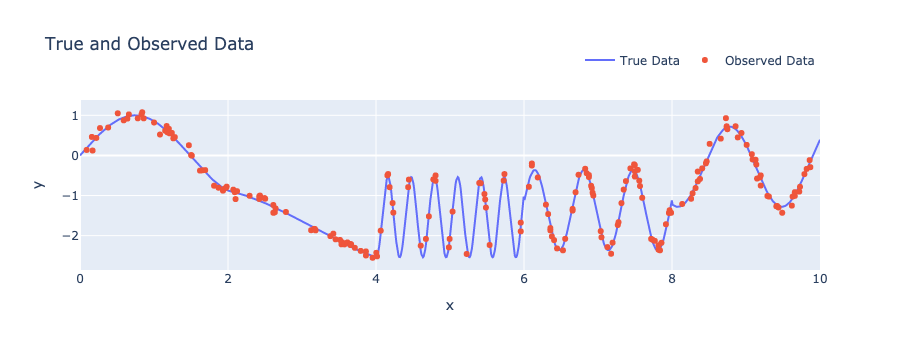

In [3]:
# Plot the data

fig = go.Figure()

# Plot true function and sampled noisy data
fig.add_trace(go.Scatter(x=true_x, y=true_y, mode="lines", name="True Data"))
fig.add_trace(go.Scatter(x=obs_x, y=obs_y, mode="markers", name="Observed Data"))

# Update layout
fig.update_xaxes(range=[0, 10])
fig.update_layout(title="True and Observed Data", xaxis_title="x", yaxis_title="y")
fig.update_layout(
    legend=dict(orientation="h", yanchor="bottom", y=1.15, xanchor="right", x=1)
)

if image_type == "html":
    fig.show()
elif image_type == "static":
    display(Image(fig.to_image(format="png", width=900, height=350)))


## Method: Naive Stationary Kernel

In [4]:
# Define the model and likeligood


class NaiveStationaryGP(gpytorch.models.ExactGP):
    """A stationary GP model with a single kernel. RBF kernel is used for simplicity."""

    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)

        # Define the mean and covariance modules
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [5]:
# Initialize likelihood and model
train_x, train_y = obs_x, obs_y
likelihood = gpytorch.likelihoods.GaussianLikelihood()
naive_stationary_model = NaiveStationaryGP(train_x, train_y, likelihood)

In [6]:
# Train the model

n_epochs = 200
lr = 0.1

naive_stationary_model.train()
likelihood.train()

# Initialize optimizer
optimizer = torch.optim.Adam(naive_stationary_model.parameters(), lr=0.1)

# Loss function for GP
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, naive_stationary_model)

# Training loop
for i in range(n_epochs):
    optimizer.zero_grad()
    output = naive_stationary_model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    if i % 10 == 0:
        print(f"Epoch {i + 1}/{n_epochs} - Loss: {loss.item():.3f}")

    optimizer.step()

Epoch 1/200 - Loss: 1.059
Epoch 11/200 - Loss: 0.819
Epoch 21/200 - Loss: 0.530
Epoch 31/200 - Loss: 0.303
Epoch 41/200 - Loss: 0.128
Epoch 51/200 - Loss: 0.063
Epoch 61/200 - Loss: 0.071
Epoch 71/200 - Loss: 0.063
Epoch 81/200 - Loss: 0.061
Epoch 91/200 - Loss: 0.061
Epoch 101/200 - Loss: 0.061
Epoch 111/200 - Loss: 0.061
Epoch 121/200 - Loss: 0.061
Epoch 131/200 - Loss: 0.061
Epoch 141/200 - Loss: 0.061
Epoch 151/200 - Loss: 0.061
Epoch 161/200 - Loss: 0.061
Epoch 171/200 - Loss: 0.061
Epoch 181/200 - Loss: 0.061
Epoch 191/200 - Loss: 0.061


In [7]:
# Evaluate the model

naive_stationary_model.eval()
likelihood.eval()

num_posterior_samples = 12

with torch.no_grad():
    # Get posterior distribution
    test_preds = naive_stationary_model(true_x)

    # Get mean and confidence bounds
    mean = test_preds.mean
    lower, upper = test_preds.confidence_region()

    # Draw samples from the posterior
    samples = test_preds.sample(sample_shape=torch.Size([num_posterior_samples]))

In [8]:
# Evaluate the minimum loss for a range of fixed length-scales

length_scales = torch.logspace(np.log10(0.001), np.log10(5.0), 40)
min_loss = np.ones(length_scales.shape[0]) * np.inf

for i, length_scale in enumerate(length_scales):
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    fixed_lengthscale_model = NaiveStationaryGP(train_x, train_y, likelihood)
    fixed_lengthscale_model.train()
    likelihood.train()

    # Set the length-scale of the kernel
    fixed_lengthscale_model.covar_module.base_kernel.lengthscale = length_scale

    # Set the noise of the likelihood
    likelihood.noise = 0.1

    # Initialize optimizer
    optimizer = torch.optim.Adam(fixed_lengthscale_model.parameters(), lr=0.01)

    # Loss function for GP
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, fixed_lengthscale_model)

    # Training loop
    for _ in range(n_epochs):
        optimizer.zero_grad()
        output = fixed_lengthscale_model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()

    # Evaluate the loss
    with torch.no_grad():
        test_preds = fixed_lengthscale_model(train_x)
        loss = -mll(test_preds, train_y)
        min_loss[i] = loss.item()
        print(f"Length-scale: {length_scale:.2e} - Loss: {loss.item():.3f}")


Length-scale: 1.00e-03 - Loss: 1.519
Length-scale: 1.24e-03 - Loss: 1.519
Length-scale: 1.55e-03 - Loss: 0.591
Length-scale: 1.93e-03 - Loss: 0.508
Length-scale: 2.40e-03 - Loss: 0.461
Length-scale: 2.98e-03 - Loss: 0.434
Length-scale: 3.71e-03 - Loss: 0.413
Length-scale: 4.61e-03 - Loss: 0.362
Length-scale: 5.74e-03 - Loss: 0.276
Length-scale: 7.14e-03 - Loss: 0.199
Length-scale: 8.88e-03 - Loss: 0.141
Length-scale: 1.10e-02 - Loss: 0.101
Length-scale: 1.37e-02 - Loss: 0.082
Length-scale: 1.71e-02 - Loss: 0.079
Length-scale: 2.13e-02 - Loss: 0.083
Length-scale: 2.65e-02 - Loss: 0.087
Length-scale: 3.29e-02 - Loss: 0.093
Length-scale: 4.10e-02 - Loss: 0.099
Length-scale: 5.10e-02 - Loss: 0.106
Length-scale: 6.34e-02 - Loss: 0.113
Length-scale: 7.89e-02 - Loss: 0.118
Length-scale: 9.81e-02 - Loss: 0.119
Length-scale: 1.22e-01 - Loss: 0.115
Length-scale: 1.52e-01 - Loss: 0.109
Length-scale: 1.89e-01 - Loss: 0.107
Length-scale: 2.35e-01 - Loss: 0.093
Length-scale: 2.92e-01 - Loss: 0.070
L

## Plotting Results

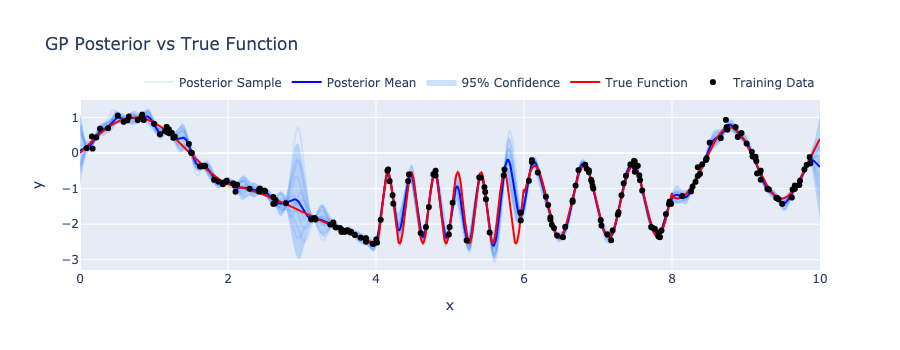

In [9]:
# Plot the results
fig = go.Figure()

# Plot posterior samples
for i in range(num_posterior_samples):
    fig.add_trace(
        go.Scatter(
            x=true_x,
            y=samples[i],
            mode="lines",
            line=dict(color="rgba(0,100,255,0.1)"),
            name="Posterior Sample",
            legendgroup="posterior_sample",
            showlegend=(i == 0),
        )
    )

# Plot mean prediction
fig.add_trace(
    go.Scatter(
        x=true_x,
        y=mean,
        mode="lines",
        line=dict(color="blue"),
        name="Posterior Mean",
    )
)

# Plot confidence bounds
fig.add_trace(
    go.Scatter(
        x=torch.cat([true_x, true_x.flip(0)]),
        y=torch.cat([upper, lower.flip(0)]),
        fill="toself",
        fillcolor="rgba(0,100,255,0.2)",
        line=dict(color="rgba(255,255,255,0)"),
        name="95% Confidence",
    )
)

# Plot true function
fig.add_trace(
    go.Scatter(
        x=true_x,
        y=true_y,
        mode="lines",
        line=dict(color="red"),
        name="True Function",
    )
)

# Plot training data
fig.add_trace(
    go.Scatter(
        x=train_x,
        y=train_y,
        mode="markers",
        marker=dict(color="black"),
        name="Training Data",
    )
)

# Update axes
fig.update_xaxes(range=[0, 10])
fig.update_layout(
    title="GP Posterior vs True Function", xaxis_title="x", yaxis_title="y"
)
fig.update_layout(
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

if image_type == "html":
    fig.show()
elif image_type == "static":
    display(Image(fig.to_image(format="png", width=900, height=350)))

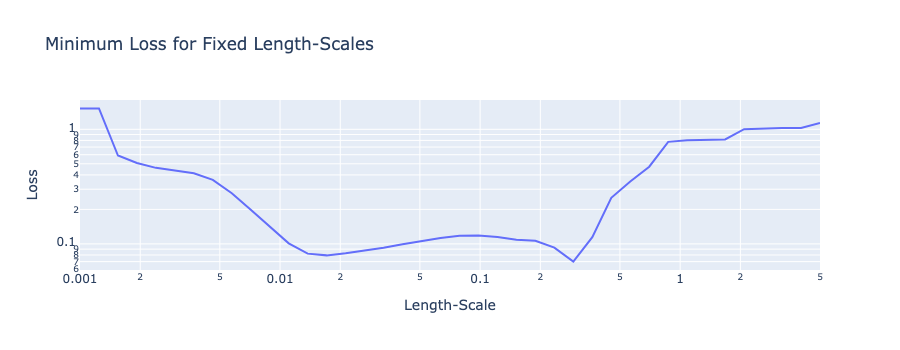

In [10]:
# Plot the minimum loss for a range of fixed length-scales

fig = go.Figure()
fig.add_trace(go.Scatter(x=length_scales, y=min_loss, mode="lines"))
fig.update_xaxes(type="log")
fig.update_yaxes(type="log")
fig.update_layout(
    title="Minimum Loss for Fixed Length-Scales",
    xaxis_title="Length-Scale",
    yaxis_title="Loss",
)

if image_type == "html":
    fig.show()
elif image_type == "static":
    display(Image(fig.to_image(format="png", width=900, height=350)))